# POS tagging using modified Viterbi

## Problem Statement:
In this assignment, we need to 
- Modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

## Solution
- Technique I: Using transition probability of tags when emission probability is zero because of unknown words
- Technique II: Using bigram backed up by the rule based tagger for unknown words



## Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

Now we have list of POS tag sentances from wsj corpus

In [3]:
# Printing first two elements of above list. Note: each list is a sentance
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

### Splitting into Train and Test Sets

In [4]:
# splitting into train and test
random.seed(123)
train_set, test_set = train_test_split(nltk_data, test_size=0.3)

print(len(train_set))
print(len(test_set))

2739
1175


In [5]:
# Getting list of tagged words in training set
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)
train_tagged_words[:10]

[('The', 'DET'),
 ('Midwest', 'NOUN'),
 ('Financial', 'NOUN'),
 ('subsidiary', 'NOUN'),
 ('banks', 'NOUN'),
 ('will', 'VERB'),
 ('continue', 'VERB'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('operate', 'VERB')]

In [6]:
# Getting list of tagged words in test set
test_tagged_words = [tup for sent in test_set for tup in sent]
len(test_tagged_words)
test_tagged_words[:10]

[('He', 'PRON'),
 ('spends', 'VERB'),
 ('his', 'PRON'),
 ('days', 'NOUN'),
 ('*-1', 'X'),
 ('sketching', 'VERB'),
 ('passers-by', 'NOUN'),
 (',', '.'),
 ('or', 'CONJ'),
 ('*-1', 'X')]

In [7]:
# Words in training set
train_words = [pair[0] for pair in train_tagged_words]
print(train_words[:10])

['The', 'Midwest', 'Financial', 'subsidiary', 'banks', 'will', 'continue', '*-1', 'to', 'operate']


In [8]:
# How many words are present in training set
training_vocabulary_set = set(train_words)
print(len(training_vocabulary_set))

10307


In [9]:
# How many tags are present in training set
training_pos_tag_set = set([pair[1] for pair in train_tagged_words])
print(len(training_pos_tag_set))
print(training_pos_tag_set)

12
{'DET', 'PRON', 'VERB', 'PRT', 'ADJ', 'NUM', 'CONJ', '.', 'ADP', 'X', 'NOUN', 'ADV'}


In [10]:
# Words in test set
test_words = [pair[0] for pair in test_tagged_words]
print(test_words[:10])

['He', 'spends', 'his', 'days', '*-1', 'sketching', 'passers-by', ',', 'or', '*-1']


In [11]:
# How many words are present in test set
test_vocabulary_set = set(test_words)
print(len(test_vocabulary_set))

6182


In [12]:
# How many tags are present in test set
test_pos_tag_set = set([pair[1] for pair in test_tagged_words])
print(len(test_pos_tag_set))
print(test_pos_tag_set)

12
{'PRON', 'DET', 'VERB', 'PRT', 'ADJ', 'NUM', 'CONJ', '.', 'ADP', 'X', 'NOUN', 'ADV'}


## Build the vanilla Viterbi based POS tagger

### Emission Probability

In [13]:
# Function to find the emission probability of a given word
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probability

In [14]:
# Function to find the transition probability of a given tag and previous tag

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# computing P(w/t) and storing in Tags x Vocabulary matrix
t = len(training_pos_tag_set)
v = len(training_vocabulary_set)
w_given_t = np.zeros((t, v))

In [16]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(training_pos_tag_set), len(training_pos_tag_set)), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [17]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))
tags_df

,DET,PRON,VERB,PRT,ADJ,NUM,CONJ,.,ADP,X,NOUN,ADV
DET,0.005857,0.004230,0.038230,0.000163,0.206768,0.023101,0.000488,0.018383,0.009761,0.043273,0.636733,0.013014
PRON,0.009160,0.008142,0.475827,0.011196,0.072265,0.008651,0.006107,0.042239,0.023919,0.092621,0.215267,0.034606
VERB,0.135704,0.035346,0.170839,0.031138,0.067431,0.024406,0.006312,0.033453,0.089207,0.216495,0.108037,0.081633
PRT,0.094516,0.018725,0.407936,0.001783,0.087383,0.055729,0.001783,0.040571,0.020062,0.014267,0.246545,0.010700
ADJ,0.005045,0.000439,0.011406,0.011187,0.067339,0.019083,0.013819,0.067339,0.084010,0.021935,0.694012,0.004387
NUM,0.004003,0.001201,0.019215,0.024019,0.035629,0.185749,0.013611,0.116894,0.036429,0.215372,0.344676,0.003203
CONJ,0.121326,0.058161,0.155722,0.003127,0.110694,0.042527,0.000625,0.036273,0.060663,0.008130,0.350219,0.052533
.,0.174399,0.065339,0.089385,0.002550,0.045300,0.079548,0.060602,0.090843,0.091329,0.025747,0.225285,0.049551
ADP,0.326308,0.073118,0.008459,0.001434,0.104516,0.065520,0.000717,0.040143,0.018495,0.034122,0.313692,0.013477
X,0.052893,0.056995,0.205527,0.188040,0.018351,0.002159,0.009931,0.160622,0.144862,0.075130,0.059370,0.026123


### Exploratory Data Analysis

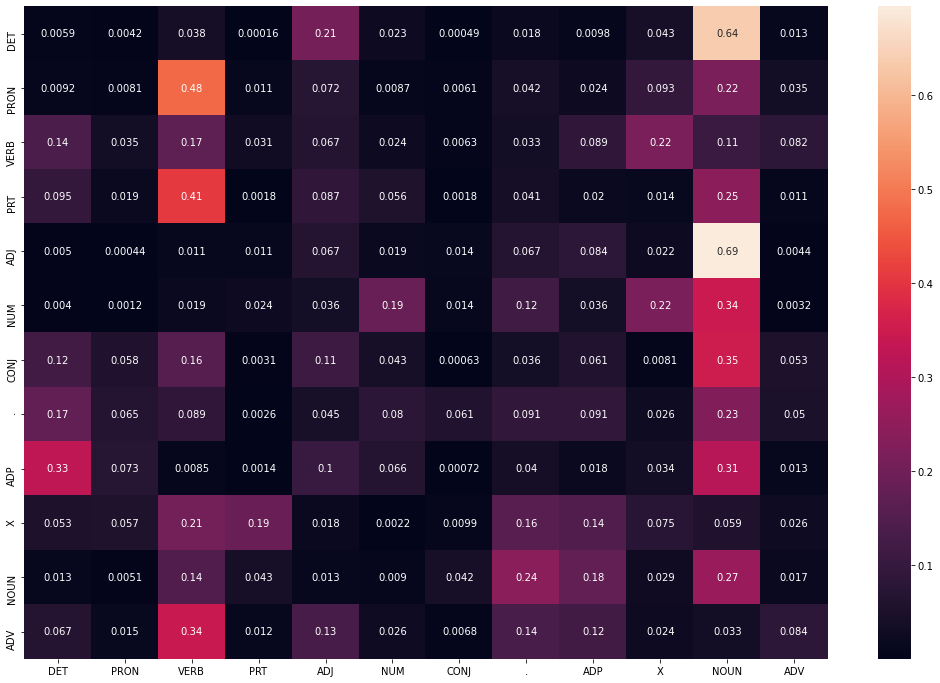

In [18]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df,annot = True)
plt.show()


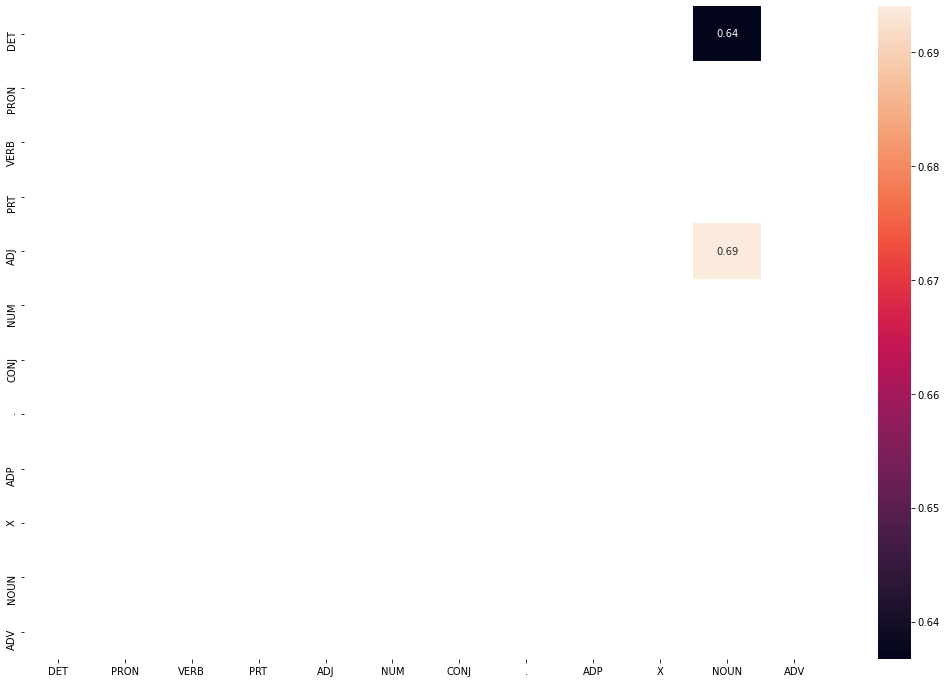

In [19]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent,annot = True)
plt.show()

## Viterbi Algorithm

Below steps are followed:

- We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set.
- Assign the tag having the max P(tag/w).
- Store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. 
- Each tuple will be a (token, assigned_tag). 
- As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [20]:
len(train_tagged_words)

70902

In [21]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [22]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('And', 'CONJ'),
  ('some', 'DET'),
  ('investment', 'NOUN'),
  ('bankers', 'NOUN'),
  ('say', 'VERB'),
  ('0', 'X'),
  ('a', 'DET'),
  ('restructuring', 'NOUN'),
  ('is', 'VERB'),
  ("n't", 'ADV'),
  ('feasible', 'ADJ'),
  ('while', 'ADP'),
  ('the', 'DET'),
  ('SEC', 'NOUN'),
  ('still', 'ADV'),
  ('is', 'VERB'),
  ('scrutinizing', 'VERB'),
  ('Mr.', 'NOUN'),
  ('Spiegel', 'NOUN'),
  ("'s", 'PRT'),
  ('past', 'ADJ'),
  ('junk-bond', 'NOUN'),
  ('trades', 'NOUN'),
  ('.', '.')],
 [('Despite', 'ADP'),
  ('recent', 'ADJ'),
  ('declines', 'NOUN'),
  ('in', 'ADP'),
  ('yields', 'NOUN'),
  (',', '.'),
  ('investors', 'NOUN'),
  ('continue', 'VERB'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('pour', 'VERB'),
  ('cash', 'NOUN'),
  ('into', 'ADP'),
  ('money', 'NOUN'),
  ('funds', 'NOUN'),
  ('.', '.')],
 [('Bordeaux', 'NOUN'),
  ("'s", 'PRT'),
  ('first', 'ADJ'),
  ('growths', 'NOUN'),
  ('from', 'ADP'),
  ('1985', 'NUM'),
  ('and', 'CONJ'),
  ('1986', 'NUM'),
  ('are', 'VERB'),
  ('$', '.'),
  

In [23]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print('Time taken in seconds : ', difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = len(check)/len(tagged_seq)
print("Vanilla Viterbi Algorithm Accuracy : ", vanilla_viterbi_accuracy*100)

Time taken in seconds :  13.91980791091919
Vanilla Viterbi Algorithm Accuracy :  90.07633587786259


In [24]:
# Check the incorrect tagged words
incorrect_tagged_words = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

print("Total Incorrect Tagged Words :", len(incorrect_tagged_words))
print("\n")
print("Incorrect Tagged Words :", incorrect_tagged_words)

Total Incorrect Tagged Words : 13


Incorrect Tagged Words : [[('to', 'PRT'), (('pour', 'DET'), ('pour', 'VERB'))], [('the', 'DET'), (('smallest', 'DET'), ('smallest', 'ADJ'))], [('which', 'DET'), (('*T*-162', 'DET'), ('*T*-162', 'X'))], [('*T*-162', 'X'), (('costs', 'NOUN'), ('costs', 'VERB'))], [('costs', 'VERB'), (('around', 'ADP'), ('around', 'ADV'))], [('In', 'ADP'), (('1973', 'DET'), ('1973', 'NUM'))], [(',', '.'), (('Wells', 'DET'), ('Wells', 'NOUN'))], [('Wells', 'NOUN'), (('Fargo', 'DET'), ('Fargo', 'NOUN'))], [('Gold', 'NOUN'), (('Account', 'DET'), ('Account', 'NOUN'))], [('which', 'DET'), (('*T*-198', 'DET'), ('*T*-198', 'X'))], [(',', '.'), (('safe-deposit', 'DET'), ('safe-deposit', 'ADJ'))], [('and', 'CONJ'), (('travelers', 'DET'), ('travelers', 'NOUN'))], [('under', 'ADP'), (('investigation', 'DET'), ('investigation', 'NOUN'))]]


## Solve the problem of unknown words

### Using Lexicon and Rule-Based Models for POS Tagging

In [25]:
# Lexicon (or unigram) tagger
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger is :", unigram_tagger_accuracy)

The accuracy of the Unigram Tagger is : 0.8916168469134144


Combining the unigram tagger with a rule based regex tagger.

In [26]:
# patterns for tagging using a rule based regex tagger

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [27]:
# rule based tagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

rule_based_unigram_tagger_accuracy = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the Rule based is : ", rule_based_unigram_tagger_accuracy)

The accuracy of the Unigram Tagger backed up by the Rule based is :  0.9302747363471485


In [28]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff=rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
bigram_rule_based_unigram_tagger_accuracy = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed up by unigram tagger backed up by rule-based tagger is : ", bigram_rule_based_unigram_tagger_accuracy)

The accuracy of the Bigram Tagger backed up by unigram tagger backed up by rule-based tagger is :  0.9338348895009069



Let's now modify the viterbi algorithm to use this bigram tagger as a back-off.
When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

# Viterbi Modification-Technique I

In [29]:
# Use transition probability of tags when emission probability is zero because of unknown words

def Viterbi_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
              
        # if probability is zero because unknown words then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [30]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_Unknown_Words(test_tagged_words)
end = time.time()
difference = end-start

print('Time taken in seconds : ', difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_modified_accuracy = len(check)/len(tagged_seq)
print('Viterbi Unknown Words Accuracy : ', vanilla_viterbi_modified_accuracy*100)

Time taken in seconds :  14.424712181091309
Viterbi Unknown Words Accuracy :  93.89312977099237


# Viterbi Modification-Technique II

In [31]:
# A bigram tagger backed off by a rule based tagger.

def bigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # bigram backed up by the regex tagger
    bigram_regex_tagger = nltk.BigramTagger(train_set, backoff = regex_based_tagger)
    return bigram_regex_tagger.tag_sents([[(word)]])

In [32]:
# Using bigram backed up by the regex tagger for unknown words

def Viterbi_Bigram_Tagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from bigram tagger
        if word not in training_vocabulary_set:
            unk_word_tag = bigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])                    
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [33]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_Bigram_Tagger(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds : ", difference)

# accuracy
viterbi_bigram_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_bigram_accuracy = len(viterbi_bigram_word_check)/len(tagged_seq) * 100
print('Viterbi Bigram Tagger Accuracy : ', viterbi_bigram_accuracy)

Time taken in seconds :  25.80893588066101
Viterbi Bigram Tagger Accuracy :  97.70992366412213


## Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [34]:
comparing_acccuracy = [['Vanilla Viterbi', vanilla_viterbi_accuracy], 
                  ['Vanilla Viterbi Modified', vanilla_viterbi_modified_accuracy], 
                  ['Unigram Tagger', unigram_tagger_accuracy * 100],
                  ['Rule Based + Unigram', rule_based_unigram_tagger_accuracy * 100],
                  ['Bigram Tagger + Rule Based + Unigram', bigram_rule_based_unigram_tagger_accuracy*100],
                  ['Viterbi + Bigram_tagger', viterbi_bigram_accuracy]]

comparing_acccuracy_df = pd.DataFrame(comparing_acccuracy, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

comparing_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

comparing_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,0.900763
Vanilla Viterbi Modified,0.938931
Unigram Tagger,89.161685
Rule Based + Unigram,93.027474
Bigram Tagger + Rule Based + Unigram,93.383489
Viterbi + Bigram_tagger,97.709924


## List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [35]:
sent_test_1 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sent_test_1)
tagged_seq_viterbi = Viterbi(words)
print(tagged_seq_viterbi)

[('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'DET'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'DET'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]


In [36]:
tagged_seq_viterbi_bigram_tagger = Viterbi_Bigram_Tagger(words)
print(tagged_seq_viterbi_bigram_tagger)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [37]:
sent_test_2 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
words = word_tokenize(sent_test_2)
tagged_seq_viterbi = Viterbi(words)
print(tagged_seq_viterbi)

[('NASA', 'DET'), ('invited', 'DET'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'DET'), ('Satellite', 'DET'), ('.', '.')]


In [38]:
tagged_seq_viterbi_bigram_tagger = Viterbi_Bigram_Tagger(words)
print(tagged_seq_viterbi_bigram_tagger)

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]


In [39]:
sent_test_3 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
words = word_tokenize(sent_test_3)
tagged_seq_viterbi = Viterbi(words)
print(tagged_seq_viterbi)

[('The', 'DET'), ('2018', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'DET'), ('contested', 'DET'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [40]:
tagged_seq_viterbi_bigram_tagger = Viterbi_Bigram_Tagger(words)
print(tagged_seq_viterbi_bigram_tagger)

[('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


Below is the analysis:

- The words Android, OS, NASA, ICESAT-2, Satellite, FIFA were incorrectly tagged which got corrected as NOUN
- The words 2013, 2011, 2018 were incorrectly tagged which got corrected as NUM
- The word best-selling was incorrectly tagged which got corrected as ADJ